In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Import the necessary libraries to implemnet it.
#!pip install tensorflow==1.14.0
import numpy as np
import pandas as pd
import keras
import tensorflow as tf
import ssl
import math
import matplotlib.pyplot as plt
import operator

from collections import defaultdict
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import confusion_matrix, classification_report, f1_score,accuracy_score
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, LSTM
from tensorflow.keras.layers import Conv1D, MaxPooling1D,BatchNormalization,GlobalMaxPooling1D,MaxPooling1D
from keras.regularizers import l2,l1
from keras.utils import to_categorical
from keras.optimizers import RMSprop, SGD, adam

# Import the Arrhythmia dataset from the library and replace missing values by '?'.
repo_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/arrhythmia/arrhythmia.data"
ssl._create_default_https_context = ssl._create_unverified_context
df = pd.read_csv(repo_url, delimiter=',', header=None,)

# Make sure the data frame has 452 rows along with 280 columns.
df.shape

(452, 280)

In [3]:
# Split the frame as Data attribute and Class
df_data = df.iloc[:,:-1]
df_class = df.iloc[:,-1]

# Replace ? by NaN
df_data = df_data.replace('?', np.NaN)

# Remove unwanted columns
# Deleting the attributes having more than 40% missing values.
thresh = len(df_data) * 0.4
df_data.dropna(thresh = thresh, axis = 1, inplace = True)

# Replace Missing values
# Imputing the remaining missing values with median of the values in the column
imp_mean = SimpleImputer(missing_values=np.NaN, strategy='median')
imputer = imp_mean.fit(df_data)
df_imp = imputer.transform(df_data)
df_data = pd.DataFrame(df_imp)

# Attribute Scaling
# Normalize the values except for the class labels for each attribute using StandardScaler.
std_scaler = StandardScaler()
x_scaled = std_scaler.fit_transform(df_data.values)
df_data = pd.DataFrame(x_scaled, index = df_data.index)

print(df_data.shape)

(452, 278)


In [4]:
# Splitting into training and testing data

X_train, X_test, Y_train, Y_test = train_test_split(df_data, df_class, test_size=0.3, shuffle = True, stratify = df_class, random_state=43)

# Splitting into training and validation data
#X_train, X_val, Y_train, Y_val = train_test_split(X_trainval, Y_trainval, test_size=0.2, shuffle = True, stratify = Y_trainval, random_state=43)

print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(316, 278) (316,) (136, 278) (136,)


Components from Feature selection using PCA (Having Eigen values >=1)- 88

Feature Selection using PCA complete for the train data.




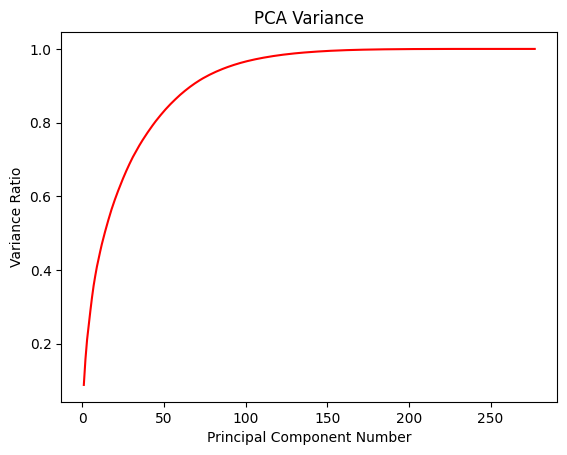

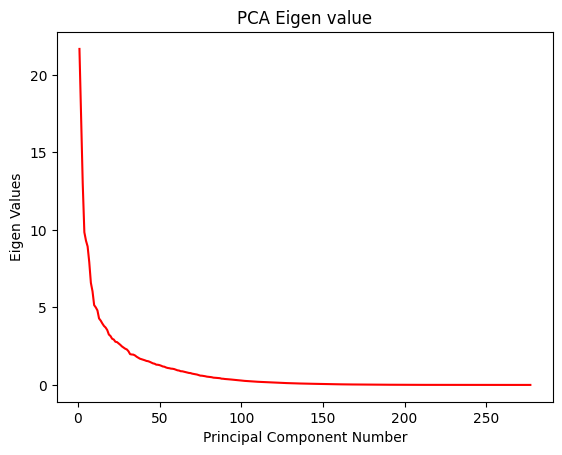

In [5]:
# Implementation of PCA
pca_dict = {}
eigen_dict = {}
for n_comp in df_data.columns:
  pca = PCA(n_components=n_comp)
  temp_train_pca = pca.fit_transform(X_train)
  temp_test_pca = pca.transform(X_test)
  eigen_values = pca.explained_variance_[:n_comp]

  if n_comp > 0:
    #print (n_comp,pca.explained_variance_ratio_.sum(),eigen_values)[-1])
    pca_dict[n_comp] = pca.explained_variance_ratio_.sum()
    eigen_dict[n_comp] = eigen_values[-1]

f = plt.figure(1)
f.patch.set_facecolor('white')
plt.title('PCA Variance')
plt.xlabel('Principal Component Number')
plt.ylabel('Variance Ratio')
plt.plot(list(pca_dict.keys()),list(pca_dict.values()),'r')
f.show()

g = plt.figure(2)
g.patch.set_facecolor('white')
plt.title('PCA Eigen value')
plt.xlabel('Principal Component Number')
plt.ylabel('Eigen Values')
plt.plot(list(eigen_dict.keys()),list(eigen_dict.values()),'r')
g.show()

# Selecting components with Eigen value greater than 1 from the list
#pca_comp_eigen = max([key for key,val in eigen_dict.items() if val >= 1])
pca_comp_eigen = max([key for key,val in pca_dict.items() if val < 0.95])

print('Components from Feature selection using PCA (Having Eigen values >=1)- ' + str(pca_comp_eigen) + '\n')

# Performing PCA for the train data with the fixed components
pca = PCA(n_components=pca_comp_eigen)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
print('Feature Selection using PCA complete for the train data.\n\n')

In [6]:
# Implementation for Random forest
rfc = SelectFromModel(RandomForestClassifier(n_estimators = 20, random_state=0, n_jobs = -1))
rfc.fit(X_train, Y_train)

rfc_comp = X_train.columns[(rfc.get_support())]
print("Components from Feature Selection using Random Forest Classifier - ",len(rfc_comp))

# Transform the model to contain only the new data.
X_train_rfc= rfc.transform(X_train)
X_test_rfc = rfc.transform(X_test)
# Confirm that the transformed model has reduced components only
print(len(X_train_rfc[0]), len(X_test_rfc[0]))

Components from Feature Selection using Random Forest Classifier -  99
99 99


SVM Accuracies - PCA: 
Linear kernal has maximum accuracy - 0.7353 for critical factor 0.01

Radial Basis Function Kernel SVM accuracy - 0.6618 for critical factor 100

Polynomial Kernel SVM has maximum accuracy - 0.6838 for critical factor 1000

Sigmoid Kernel SVM has maximum accuracy - 0.6985 for critical factor 1




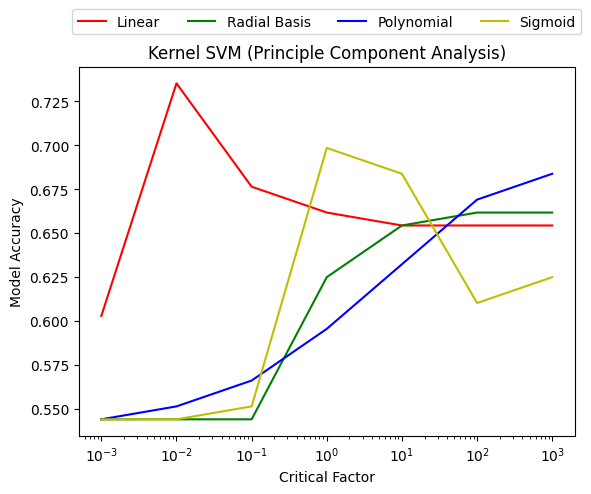

In [7]:
# Hyperaeter tuning on regularization parameter and kernal for SVM
c_list = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
kernals = ['linear','rbf','poly','sigmoid']

pca_accuracy = {'linear':[], 'rbf':[], 'poly':[], 'sigmoid':[]}
#pca_f1_score = {'linear':[], 'rbf':[], 'poly':[], 'sigmoid':[]}

for kernal in kernals:
  for cval in c_list:

    clf = SVC(max_iter=100000, kernel=kernal, C=cval)

    clf.fit(X_train_pca, Y_train)
    pca_accuracy[kernal].append(clf.score(X_test_pca, Y_test))
    yPred = clf.predict(X_test_pca)
    #pca_f1_score[kernal].append(f1_score(Y_test, yPred, average='weighted'))

    del clf
    del yPred

print('SVM Accuracies - PCA: ')
print('Linear kernal has maximum accuracy - '+ str(round(max(pca_accuracy['linear']),4)) + ' for critical factor ' + str(c_list[pca_accuracy['linear'].index(max(pca_accuracy['linear']))]) )
print('\nRadial Basis Function Kernel SVM accuracy - '+ str(round(max(pca_accuracy['rbf']),4)) + ' for critical factor ' + str(c_list[pca_accuracy['rbf'].index(max(pca_accuracy['rbf']))]) )
print('\nPolynomial Kernel SVM has maximum accuracy - ' + str(round(max(pca_accuracy['poly']),4)) + ' for critical factor ' + str(c_list[pca_accuracy['poly'].index(max(pca_accuracy['poly']))]))
print('\nSigmoid Kernel SVM has maximum accuracy - ' + str(round(max(pca_accuracy['sigmoid']),4)) + ' for critical factor ' + str(c_list[pca_accuracy['sigmoid'].index(max(pca_accuracy['sigmoid']))]) +'\n\n')

# Plot the Accuracy with C values
fig = plt.figure(1)
fig.patch.set_facecolor('white')
plt.xscale('log')
plt.title('Kernel SVM (Principle Component Analysis)')
plt.xlabel('Critical Factor')
plt.ylabel('Model Accuracy')
plt.plot(c_list, pca_accuracy['linear'], 'r', label = 'Linear')
plt.plot(c_list, pca_accuracy['rbf'], 'g', label = 'Radial Basis')
plt.plot(c_list, pca_accuracy['poly'], 'b', label = 'Polynomial')
plt.plot(c_list, pca_accuracy['sigmoid'], 'y', label = 'Sigmoid')
plt.legend(bbox_to_anchor = (0., 1.02, 1., .202), loc = 10, ncol=4, borderaxespad = 0)
fig.show()



SVM Accuracies - Random Forest Classifier: 
Linear kernal has maximum accuracy - 0.7353 for critical factor 0.1

Radial Basis Function Kernel SVM accuracy - 0.7132 for critical factor 10

Polynomial Kernel SVM has maximum accuracy - 0.6765 for critical factor 10

Sigmoid Kernel SVM has maximum accuracy - 0.6985 for critical factor 1




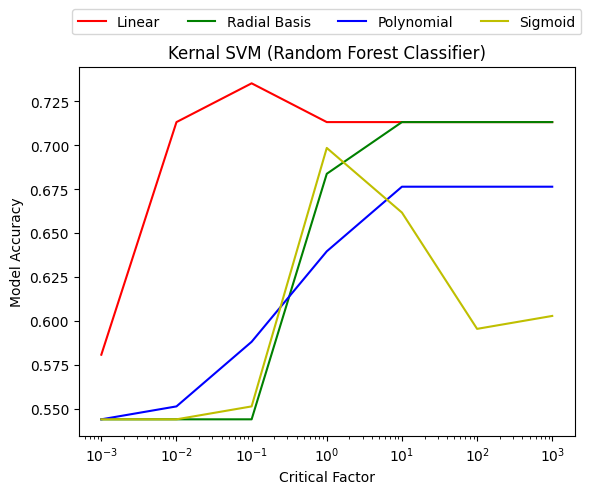

In [8]:
# Hyperaeter tuning on regularization parameter and kernal for SVM
c_list = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
kernals = ['linear','rbf','poly','sigmoid']

rfc_accuracy = {'linear':[], 'rbf':[], 'poly':[], 'sigmoid':[]}
#rfc_f1_score = {'linear':[], 'rbf':[], 'poly':[], 'sigmoid':[]}

for kernal in kernals:
  for cval in c_list:

    clf = SVC(max_iter=100000, kernel=kernal, C=cval)

    clf.fit(X_train_rfc, Y_train)
    rfc_accuracy[kernal].append(clf.score(X_test_rfc, Y_test))
    yPred = clf.predict(X_test_rfc)
    #pca_f1_score[kernal].append(f1_score(Y_test, yPred, average='weighted'))

    del clf
    del yPred

print('SVM Accuracies - Random Forest Classifier: ')
print('Linear kernal has maximum accuracy - '+ str(round(max(rfc_accuracy['linear']),4)) + ' for critical factor ' + str(c_list[rfc_accuracy['linear'].index(max(rfc_accuracy['linear']))]) )
print('\nRadial Basis Function Kernel SVM accuracy - '+ str(round(max(rfc_accuracy['rbf']),4)) + ' for critical factor ' + str(c_list[rfc_accuracy['rbf'].index(max(rfc_accuracy['rbf']))]) )
print('\nPolynomial Kernel SVM has maximum accuracy - ' + str(round(max(rfc_accuracy['poly']),4)) + ' for critical factor ' + str(c_list[rfc_accuracy['poly'].index(max(rfc_accuracy['poly']))]))
print('\nSigmoid Kernel SVM has maximum accuracy - ' + str(round(max(rfc_accuracy['sigmoid']),4)) + ' for critical factor ' + str(c_list[rfc_accuracy['sigmoid'].index(max(rfc_accuracy['sigmoid']))]) +'\n\n')

# Plot the Accuracy with C values
fig = plt.figure(1)
fig.patch.set_facecolor('white')
plt.xscale('log')
plt.title('Kernal SVM (Random Forest Classifier)')
plt.xlabel('Critical Factor')
plt.ylabel('Model Accuracy')
plt.plot(c_list, rfc_accuracy['linear'], 'r', label = 'Linear')
plt.plot(c_list, rfc_accuracy['rbf'], 'g', label = 'Radial Basis')
plt.plot(c_list, rfc_accuracy['poly'], 'b', label = 'Polynomial')
plt.plot(c_list, rfc_accuracy['sigmoid'], 'y', label = 'Sigmoid')
plt.legend(bbox_to_anchor = (0., 1.02, 1., .202), loc = 10, ncol=4, borderaxespad = 0)
fig.show()

In [9]:
#Assign the best values for the SVM parameter
clf = SVC(max_iter=100000, kernel='linear', C=0.01)

clf.fit(X_train_pca, Y_train)

yPred_svm = clf.predict(X_test_pca)

acc = accuracy_score(yPred_svm,Y_test)
print('Accuracy for SVM - Linear Kernal - ',round(acc,4))

result = classification_report(Y_test, yPred_svm)
print("\n",result)

Accuracy for SVM - Linear Kernal -  0.7353

               precision    recall  f1-score   support

           1       0.70      0.96      0.81        74
           2       0.75      0.69      0.72        13
           3       1.00      1.00      1.00         4
           4       0.60      0.75      0.67         4
           5       1.00      0.25      0.40         4
           6       0.00      0.00      0.00         8
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1
           9       1.00      0.67      0.80         3
          10       1.00      0.67      0.80        15
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         7

    accuracy                           0.74       136
   macro avg       0.47      0.38      0.40       136
weighted avg       0.66      0.74      0.68       136



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [10]:
# kNN with Euclidean distance returns distance between
def knn(testdata,k,post_train_array,class_array):
  dictionary = {}

  # Using Euclidean distance to compute the distance between the 2 vectors.
  for cnt,i in enumerate(post_train_array):
    c = math.sqrt(sum([(i[val] - testdata[val])**2 for val in range(len(i))]))
    dictionary[cnt] = [c,class_array[cnt]]



  # Sorting the counts in decreaing order and selecting the top k values from the list
  sorted_d = sorted(dictionary.items(), key=lambda x: x[1])
  required = sorted_d[0:k]
  preddic = {}
  for i in required:
    j = i
    class_values = j[1][1]
    if j[1][1] not in preddic:
      preddic[class_values] = 1
    else:
      preddic[class_values] += 1

  #identifying the majority class fromm the selected k values and return class variables.
  sorted_d = sorted(preddic.items(), key=operator.itemgetter(1))
  sorted_d = sorted_d[::-1]
  return sorted_d[0][0]


# Hyperparameter tuning for k neighbours
def kNN_k_tuning(feature,hyperparameter):
  plot_x = []
  plot_y = []

  kfoldval = 7
  kfdata = KFold(n_splits=kfoldval, shuffle = True)
  print(kfoldval,' fold kNN Cross validation Implementation for ',feature,'\n')

  # Compute the kNN for odd-k ranging between 1 - 11
  for k in range(1,13,2):

    total_accuracy = 0
    for j,i in enumerate(kfdata.split(df_data)):
      X_train = np.array(df_data)[i[0]]
      X_test = np.array(df_data)[i[1]]
      X_train, X_test = pd.DataFrame(X_train),pd.DataFrame(X_test)

      Y_train = np.array(df_class)[i[0]]
      Y_test = np.array(df_class)[i[1]]
      Y_train, Y_test = pd.Series(Y_train),pd.Series(Y_test)

      class_array = Y_train.values
      test_array = Y_test.values

      if feature =='Random Forest':
        rfc = SelectFromModel(RandomForestClassifier(n_estimators = hyperparameter, random_state=0, n_jobs = -1))
        rfc.fit(X_train, Y_train)
        rfc_comp = X_train.columns[(rfc.get_support())]
        post_train_array= rfc.transform(X_train)
        post_test_array = rfc.transform(X_test)

      elif feature =='PCA':

        pca = PCA(n_components=hyperparameter)
        post_train_array = pca.fit_transform(X_train)
        post_test_array = pca.transform(X_test)

      accuracy_count = 0
      new_count = 0

      for i in post_test_array:
        m = knn(i,k,post_train_array,class_array)
        if m==test_array[new_count]:
          accuracy_count+=1
        new_count += 1

      percentage = accuracy_count/len(test_array)
      total_accuracy += percentage

    plot_x.append(k)
    plot_y.append(total_accuracy*100/kfoldval)
    print("")
    print("kNN Accuracy with ", feature," for k -",k," is ",str(round(total_accuracy*100/kfoldval,4)))

  fig = plt.figure(1)
  fig.patch.set_facecolor('white')
  plt.title('Accuracy of 7 fold kNN using '+ feature)
  plt.xlabel('Values for K')
  plt.ylabel('Model Accuracy')
  plt.plot(plot_x, plot_y,'b')
  fig.show()

### kNN classification with PCA

7  fold kNN Cross validation Implementation for  PCA 


kNN Accuracy with  PCA  for k - 1  is  59.7081

kNN Accuracy with  PCA  for k - 3  is  60.8654

kNN Accuracy with  PCA  for k - 5  is  60.8413

kNN Accuracy with  PCA  for k - 7  is  59.5192

kNN Accuracy with  PCA  for k - 9  is  58.4238

kNN Accuracy with  PCA  for k - 11  is  56.6346


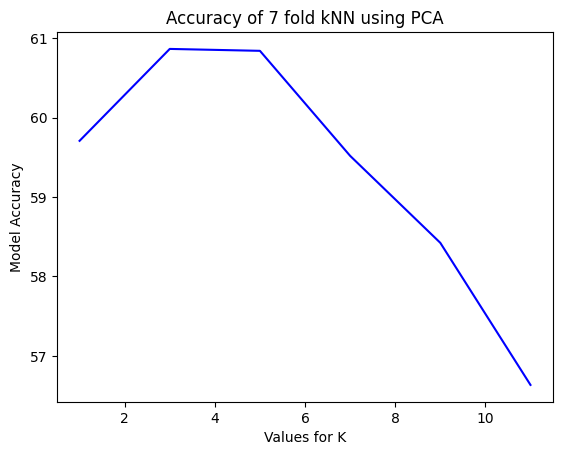

In [11]:
n_comp = 49
kNN_k_tuning('PCA',n_comp)

7  fold kNN Cross validation Implementation for  Random Forest 


kNN Accuracy with  Random Forest  for k - 1  is  61.4973

kNN Accuracy with  Random Forest  for k - 3  is  63.4993

kNN Accuracy with  Random Forest  for k - 5  is  63.9629

kNN Accuracy with  Random Forest  for k - 7  is  65.2679

kNN Accuracy with  Random Forest  for k - 9  is  62.6133

kNN Accuracy with  Random Forest  for k - 11  is  62.1772


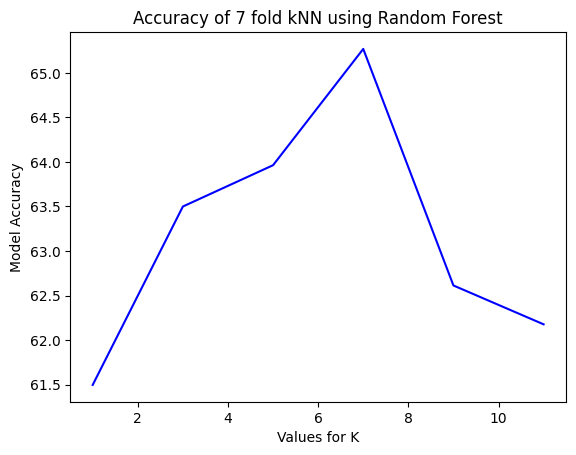

In [12]:
n_estimators = 20
kNN_k_tuning('Random Forest',n_estimators)

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
# Split the data into train and validation
X_train_cnn, X_val_cnn, Y_train_cnn, Y_val_cnn = train_test_split(X_train, Y_train, test_size=0.2,  random_state=0)

Xtrain = np.expand_dims(X_train, 2)
Ytrain = to_categorical(Y_train)
Xval = np.expand_dims(X_test, 2)
Yval = to_categorical(Y_test)
print(Xtrain.shape,Ytrain.shape,Xval.shape,Yval.shape)

print(np.bincount(Y_train))
print(np.bincount(Y_test))
print(np.bincount(Y_train_cnn))
print(np.bincount(Y_val_cnn))

(316, 278, 1) (316, 17) (136, 278, 1) (136, 17)
[  0 171  31  11  11   9  17   2   1   6  35   0   0   0   3   4  15]
[ 0 74 13  4  4  4  8  1  1  3 15  0  0  0  1  1  7]
[  0 130  25   9   9   7  13   2   1   6  31   0   0   0   2   4  13]
[ 0 41  6  2  2  2  4  0  0  0  4  0  0  0  1  0  2]


In [15]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight("balanced", classes=Y_train, y=Y_train.values)

#class_weights = class_weight.compute_class_weight('balanced', np.unique(Y_train), Y_train)
class_weights_dict = dict(zip([1,2,3,4,5,6,7,8,9,10,14,15,16], class_weights))
class_weights_dict[0] = 0
class_weights_dict[11] = 0
class_weights_dict[12] = 0
class_weights_dict[13] = 0
print(class_weights.sum())
print(class_weights_dict)

316.0
{1: 0.14215024741340532, 2: 1.4298642533936652, 3: 0.6945054945054945, 4: 0.7841191066997518, 5: 0.14215024741340532, 6: 0.6945054945054945, 7: 0.14215024741340532, 8: 0.14215024741340532, 9: 0.14215024741340532, 10: 0.14215024741340532, 14: 0.14215024741340532, 15: 0.14215024741340532, 16: 2.2097902097902096, 0: 0, 11: 0, 12: 0, 13: 0}


### delete model h5 files if experiment useless

In [16]:
!rm *.h5;

#### Defining Weighted 1D CNN model

In [17]:
#model
model = Sequential()

model.add(Conv1D(filters=64, kernel_size=10,activation='relu',kernel_initializer='he_uniform', input_shape=(278,1)))
model.add(Conv1D(filters=128, kernel_size=10,activation='relu',kernel_initializer='he_uniform'))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(17, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 269, 64)           704       
                                                                 
 conv1d_1 (Conv1D)           (None, 260, 128)          82048     
                                                                 
 dropout (Dropout)           (None, 260, 128)          0         
                                                                 
 flatten (Flatten)           (None, 33280)             0         
                                                                 
 dense (Dense)               (None, 128)               4259968   
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 17)                1

#### train the model and save best validation accuracy checkpoint

In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
batch_size= 16
no_epochs = 20

earlystop = EarlyStopping(monitor='val_accuracy', patience=20)
checkpoint = ModelCheckpoint('model-epoch-{epoch:03d}-valacc-{val_accuracy:03f}.h5', verbose=1, monitor='val_accuracy',save_best_only=True, mode='auto')

# Generate the fit model
hist = model.fit(Xtrain, Ytrain,
                 epochs=no_epochs,
                 batch_size=batch_size,
                 validation_data=(Xval, Yval),
                 callbacks=[earlystop, checkpoint],
                 class_weight = class_weights_dict)


Epoch 1/20
20/20 [==============================] - ETA: 0s - loss: 1.2786 - accuracy: 0.2278
Epoch 1: val_accuracy improved from -inf to 0.18382, saving model to model-epoch-001-valacc-0.183824.h5
20/20 [==============================] - 6s 32ms/step - loss: 1.2786 - accuracy: 0.2278 - val_loss: 2.3616 - val_accuracy: 0.1838
Epoch 2/20
11/20 [===============>..............] - ETA: 0s - loss: 0.5068 - accuracy: 0.5000
Epoch 2: val_accuracy improved from 0.18382 to 0.53676, saving model to model-epoch-002-valacc-0.536765.h5
20/20 [==============================] - 0s 13ms/step - loss: 0.4549 - accuracy: 0.5443 - val_loss: 2.0511 - val_accuracy: 0.5368
Epoch 3/20
20/20 [==============================] - ETA: 0s - loss: 0.2142 - accuracy: 0.7152
Epoch 3: val_accuracy did not improve from 0.53676
20/20 [==============================] - 0s 9ms/step - loss: 0.2142 - accuracy: 0.7152 - val_loss: 1.8600 - val_accuracy: 0.5147
Epoch 4/20
11/20 [===============>..............] - ETA: 0s - loss:

In [19]:
!cp model-epoch-010-valacc-0.661765.h5 /content/drive/Shared\ drives/ALDA\ Project/ClassWeights/

cp: cannot stat 'model-epoch-010-valacc-0.661765.h5': No such file or directory


#### Visualizing training and validation accuracy

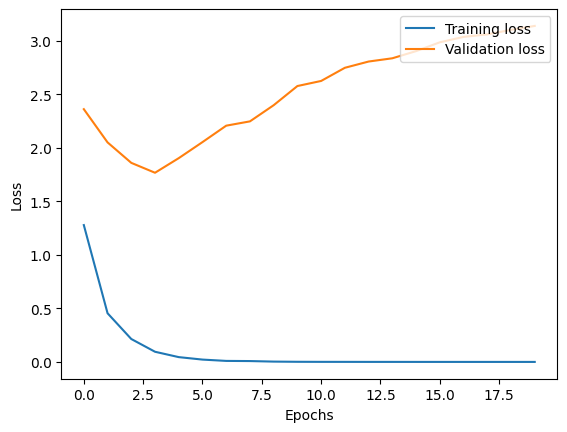

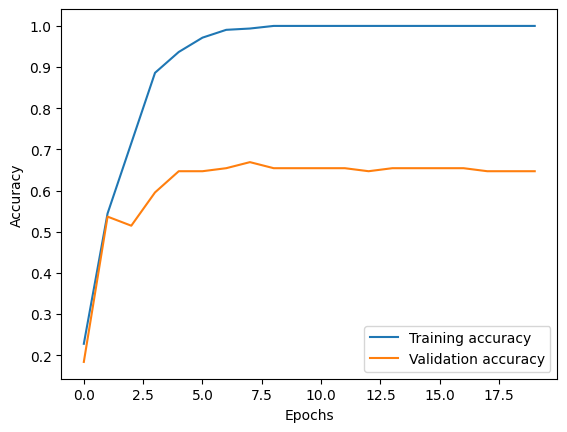

In [20]:
sub=0
# visualizing losses and accuracy
train_loss = hist.history['loss'][sub:]
val_loss = hist.history['val_loss'][sub:]
train_accu = hist.history['accuracy'][sub:]
val_accu = hist.history['val_accuracy'][sub:]
xc = range(len(val_loss))

fig1 = plt.figure()
fig1.patch.set_facecolor('white')
plt.plot(xc, train_loss, label='Training loss')
plt.plot(xc, val_loss, label='Validation loss')
plt.legend(loc="upper right")
plt.xlabel('Epochs')
plt.ylabel('Loss')
fig1.show()

fig2 = plt.figure()
fig2.patch.set_facecolor('white')
plt.plot(xc, train_accu, label='Training accuracy')
plt.plot(xc, val_accu, label='Validation accuracy')
plt.legend(loc="lower right")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
fig2.show()

In [21]:
predictions = model.predict(Xval)


5/5 [==============================] - 0s 3ms/step


In [22]:
predictions=predictions.round()

In [23]:
from numpy import argmax

In [24]:
predictions = argmax(predictions, axis=1)


In [25]:
predictions = np.array(predictions)

In [26]:

input = int(input('Enter the ECG ID  '))




Enter the ECG ID  5


In [27]:

if predictions[input]== 0:
    print("Atrial fibrillation")
elif predictions[input] == 1:
    print('Ventricular tachycardia')
elif predictions[input] == 2:
    print('Ventricular fibrillation')
elif predictions[input] == 3:
    print('Atrial flutter')
elif predictions[input] == 4:
    print('Bradycardia')
else:
    print('Sinus tachycardia')



Ventricular tachycardia
